Krishna Khandelwal
> S1364040
> Assignment-02(updated)





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


1. Exploratory Data Analysis (EDA)

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import random


In [4]:
# Load the image data and labels
images = np.load('images.npy')
labels = pd.read_csv('Labels.csv')

# Check the structure of the loaded data
print("Images shape:", images.shape)  # Check dimensions of the images
print("Labels head:\n", labels.head())  # Display the first few rows of labels


Images shape: (4750, 128, 128, 3)
Labels head:
                        Label
0  Small-flowered Cranesbill
1  Small-flowered Cranesbill
2  Small-flowered Cranesbill
3  Small-flowered Cranesbill
4  Small-flowered Cranesbill


In [5]:
# Display column names to check for issues
print("Column names in labels DataFrame:", labels.columns)


Column names in labels DataFrame: Index(['Label'], dtype='object')


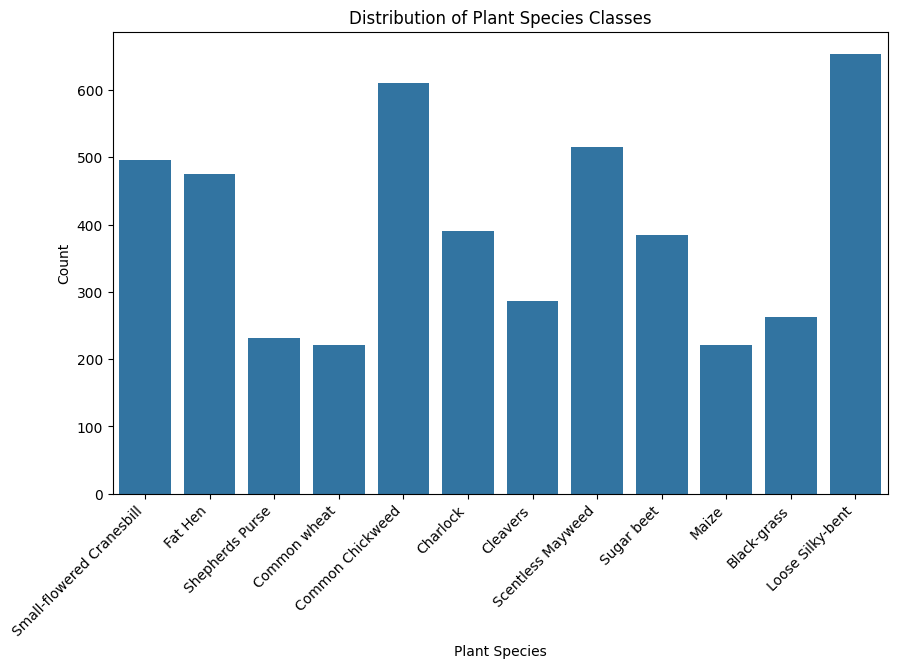

In [6]:
# Plot the distribution of plant species classes with the correct column name
plt.figure(figsize=(10, 6))
sns.countplot(data=labels, x='Label')  # Using 'Label' instead of 'species'
plt.xticks(rotation=45, ha='right')  # Rotate x labels for readability
plt.title('Distribution of Plant Species Classes')
plt.xlabel('Plant Species')
plt.ylabel('Count')
plt.show()


2. Data Preprocessing

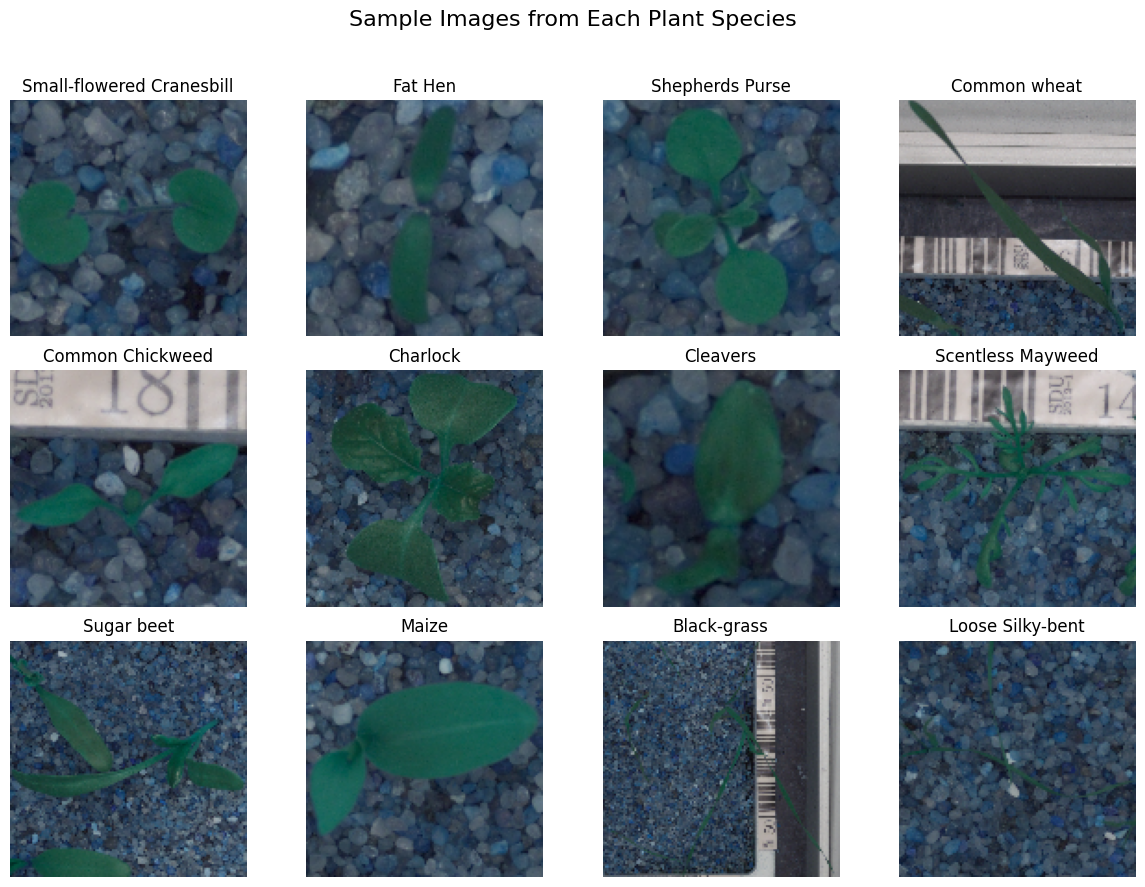

In [7]:
# Ensure we have at least 12 unique species
unique_species = labels['Label'].unique()
if len(unique_species) < 12:
    print("Not enough species to display a 3x4 grid.")
else:
    # Select one sample image per species (12 in total)
    samples_per_class = {}
    for species in unique_species[:12]:  # Limit to the first 12 unique species
        sample_index = labels[labels['Label'] == species].index[0]
        sample_image = images[sample_index]

        # Reshape or normalize if needed (check your image's original dimensions)
        if sample_image.shape[-1] != 3:  # Assuming RGB images
            sample_image = np.repeat(sample_image[..., np.newaxis], 3, axis=-1)

        samples_per_class[species] = sample_image

    # Plotting the images in a 3x4 grid
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    fig.suptitle('Sample Images from Each Plant Species', fontsize=16)

    for ax, (species, image) in zip(axes.flat, samples_per_class.items()):
        ax.imshow(image)
        ax.set_title(species)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()


In [8]:
import cv2

# Resize images to 64x64
resized_images = np.array([cv2.resize(image, (64, 64)) for image in images])
print("Resized images shape:", resized_images.shape)


Resized images shape: (4750, 64, 64, 3)


In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels as integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels['Label'])

# Convert integer-encoded labels to one-hot encoded labels
one_hot_labels = to_categorical(encoded_labels)
print("One-hot encoded labels shape:", one_hot_labels.shape)


One-hot encoded labels shape: (4750, 12)


In [10]:
# Normalize pixel values to range [0, 1]
normalized_images = resized_images / 255.0
print("Normalized images shape:", normalized_images.shape)


Normalized images shape: (4750, 64, 64, 3)


3. Model 1: Basic CNN Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define the Basic CNN architecture with a deeper dense network
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    # Dense Layers with regularization
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    # Output layer for 12 classes
    Dense(12, activation='softmax')
])

# Compile the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_1.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,307,596 (4.99 MB)

 Trainable params: 1,307,596 (4.99 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(normalized_images, one_hot_labels, test_size=0.2, random_state=42)

# Train the model
history = model_1.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val),
                    callbacks=[early_stopping], batch_size=32)


Epoch 1/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.1321 - loss: 2.7617 - val_accuracy: 0.3389 - val_loss: 1.9576
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3361 - loss: 1.9809 - val_accuracy: 0.4211 - val_loss: 1.6894
Epoch 3/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4158 - loss: 1.7201 - val_accuracy: 0.4642 - val_loss: 1.6379
Epoch 4/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4467 - loss: 1.6166 - val_accuracy: 0.5432 - val_loss: 1.3818
Epoch 5/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5234 - loss: 1.4301 - val_accuracy: 0.6126 - val_loss: 1.2071


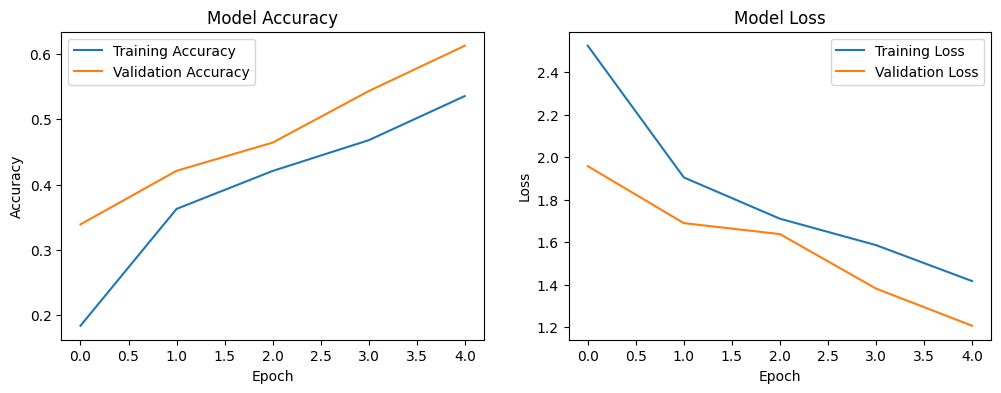

In [13]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


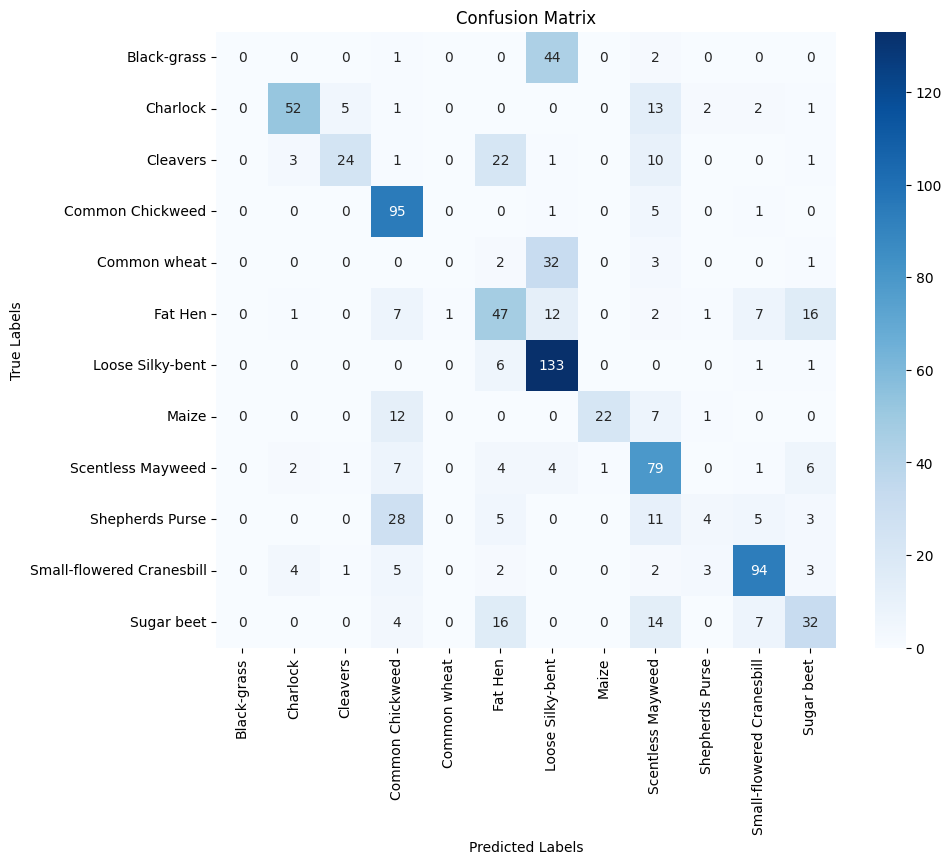

Classification Report:
                            precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        47
                 Charlock       0.84      0.68      0.75        76
                 Cleavers       0.77      0.39      0.52        62
         Common Chickweed       0.59      0.93      0.72       102
             Common wheat       0.00      0.00      0.00        38
                  Fat Hen       0.45      0.50      0.47        94
         Loose Silky-bent       0.59      0.94      0.72       141
                    Maize       0.96      0.52      0.68        42
        Scentless Mayweed       0.53      0.75      0.62       105
          Shepherds Purse       0.36      0.07      0.12        56
Small-flowered Cranesbill       0.80      0.82      0.81       114
               Sugar beet       0.50      0.44      0.47        73

                 accuracy                           0.61       950
                macro avg       0.53

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Make predictions on the validation set
y_pred = model_1.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


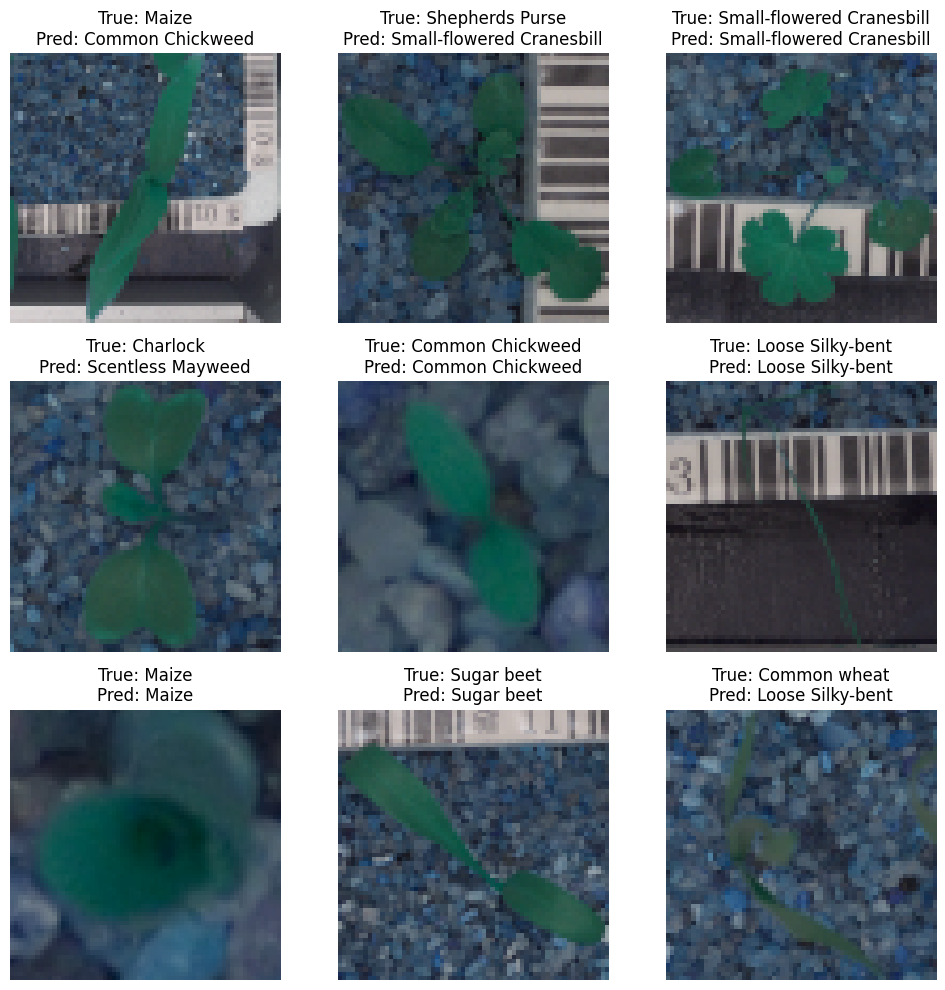

In [15]:
# Plot a few test samples with predicted and true labels
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for i in range(9):
    img = X_val[i]
    true_label = label_encoder.classes_[y_true_classes[i]]
    pred_label = label_encoder.classes_[y_pred_classes[i]]

    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


4. Model 2: Enhanced CNN with Data Augmentation and Regularization

In [16]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,       # Rotate images up to 20 degrees
    width_shift_range=0.1,   # Shift width by up to 10%
    height_shift_range=0.1,  # Shift height by up to 10%
    zoom_range=0.2,          # Zoom in by up to 20%
    horizontal_flip=True     # Randomly flip images horizontally
)

# Fit the data generator on the training data
datagen.fit(X_train)


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import SpatialDropout2D

# Define the Enhanced CNN architecture with deeper dense layers
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.4),

    Flatten(),

    # Deeper Dense Layers with regularization
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    # Output layer for 12 classes
    Dense(12, activation='softmax')
])

# Compile the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_2.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d (SpatialDropout2D) │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_1                  │ (None, 14, 14, 64)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_2                  │ (None, 6, 6, 128)           │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,308,492 (4.99 MB)

 Trainable params: 1,308,044 (4.99 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with augmented data
history_enhanced = model_2.fit(datagen.flow(X_train, y_train, batch_size=32),
                                      validation_data=(X_val, y_val),
                                      epochs=5,
                                      callbacks=[early_stopping])


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 130ms/step - accuracy: 0.1442 - loss: 4.1249 - val_accuracy: 0.0400 - val_loss: 7.1343
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.2509 - loss: 2.9522 - val_accuracy: 0.0400 - val_loss: 6.3062
Epoch 3/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.3222 - loss: 2.7471 - val_accuracy: 0.1232 - val_loss: 3.2458
Epoch 4/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.4009 - loss: 2.4982 - val_accuracy: 0.2779 - val_loss: 2.7955
Epoch 5/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4002 - loss: 2.4475 - val_accuracy: 0.4358 - val_loss: 2.2083


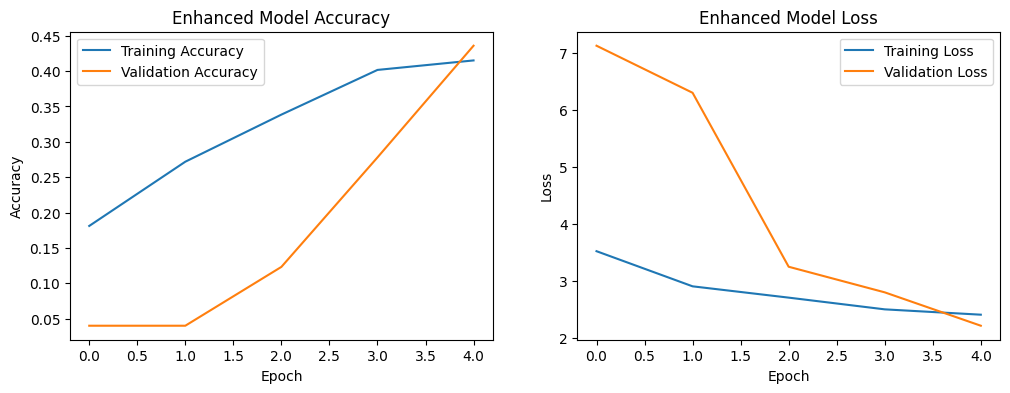

In [20]:
# Plot accuracy and loss curves for the enhanced model
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_enhanced.history['accuracy'], label='Training Accuracy')
plt.plot(history_enhanced.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Enhanced Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_enhanced.history['loss'], label='Training Loss')
plt.plot(history_enhanced.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Enhanced Model Loss')

plt.show()


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


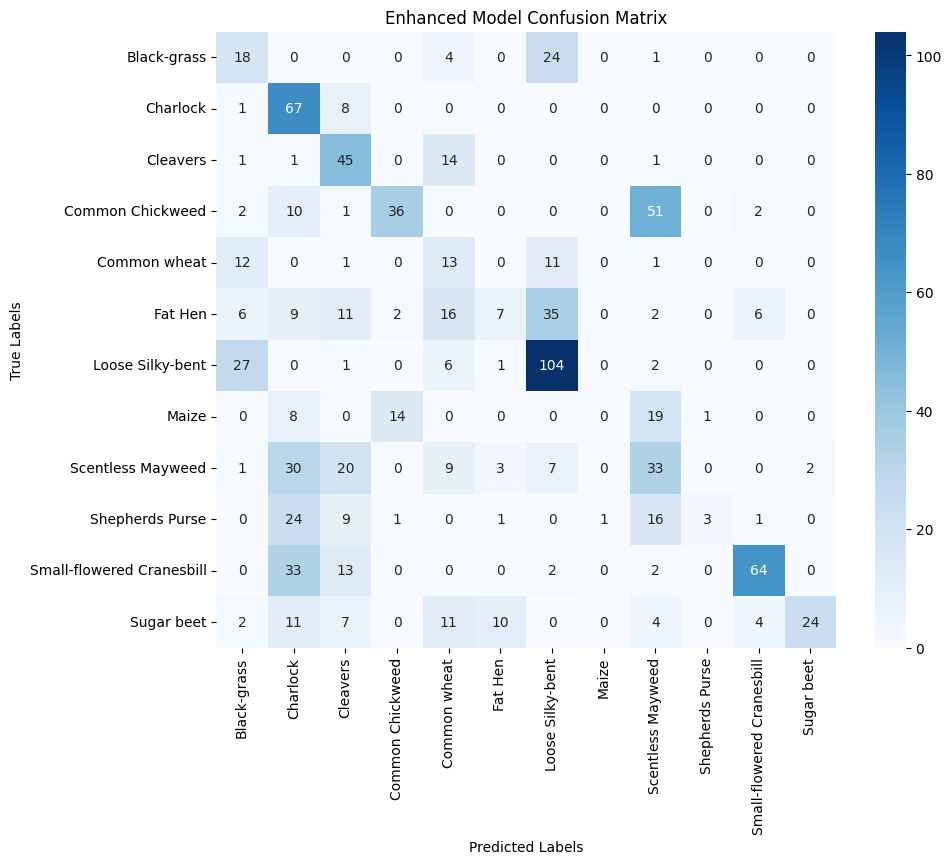

Enhanced Model Classification Report:
                            precision    recall  f1-score   support

              Black-grass       0.26      0.38      0.31        47
                 Charlock       0.35      0.88      0.50        76
                 Cleavers       0.39      0.73      0.51        62
         Common Chickweed       0.68      0.35      0.46       102
             Common wheat       0.18      0.34      0.23        38
                  Fat Hen       0.32      0.07      0.12        94
         Loose Silky-bent       0.57      0.74      0.64       141
                    Maize       0.00      0.00      0.00        42
        Scentless Mayweed       0.25      0.31      0.28       105
          Shepherds Purse       0.75      0.05      0.10        56
Small-flowered Cranesbill       0.83      0.56      0.67       114
               Sugar beet       0.92      0.33      0.48        73

                 accuracy                           0.44       950
                macro

In [21]:
# Make predictions on the validation set
y_pred_enhanced = model_2.predict(X_val)
y_pred_classes_enhanced = np.argmax(y_pred_enhanced, axis=1)
y_true_classes_enhanced = np.argmax(y_val, axis=1)

# Generate confusion matrix
conf_matrix_enhanced = confusion_matrix(y_true_classes_enhanced, y_pred_classes_enhanced)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_enhanced, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Enhanced Model Confusion Matrix')
plt.show()

# Print classification report
print("Enhanced Model Classification Report:\n",
      classification_report(y_true_classes_enhanced, y_pred_classes_enhanced, target_names=label_encoder.classes_))


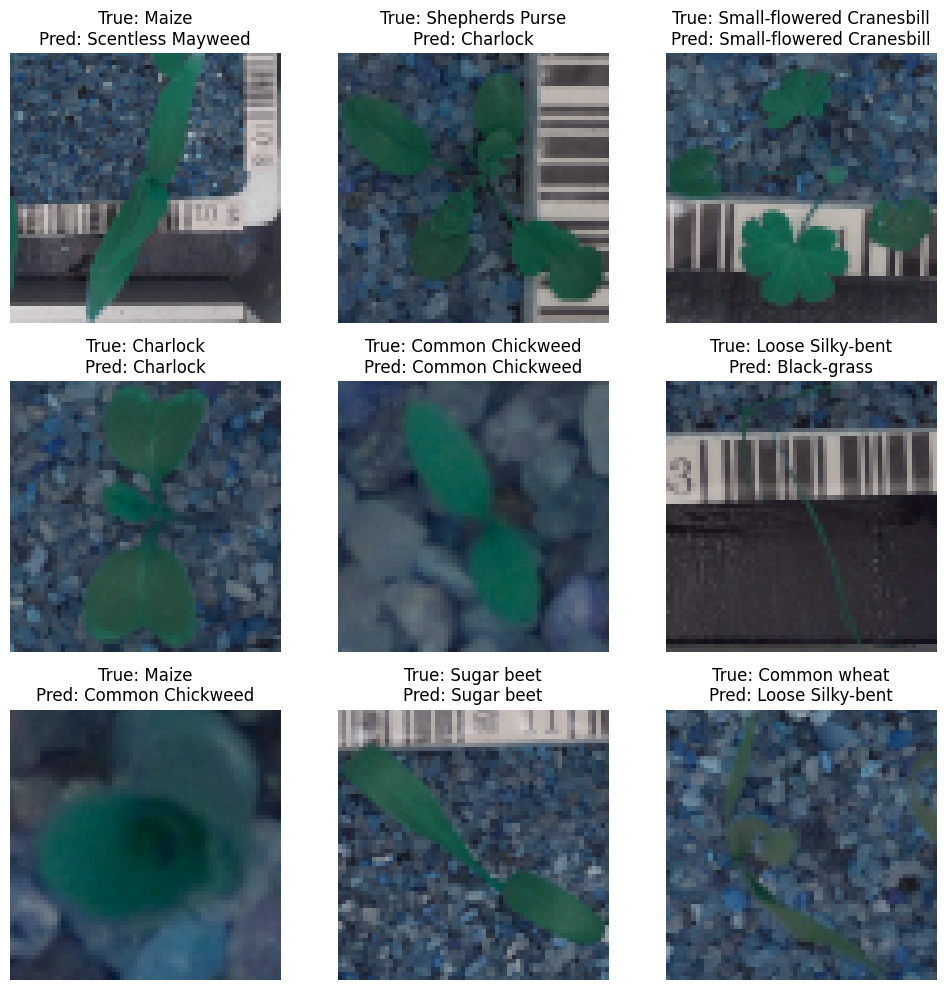

In [22]:
# Plot a few test samples with predicted and true labels
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for i in range(9):
    img = X_val[i]
    true_label = label_encoder.classes_[y_true_classes_enhanced[i]]
    pred_label = label_encoder.classes_[y_pred_classes_enhanced[i]]

    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


5. Model 3: Transfer Learning with Pre-trained Models

In [23]:
!pip install keras
!pip install keras-tuner
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, RandomSearch # This import should now work
from tensorflow.keras.regularizers import l2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


In [24]:
class TransferLearningHyperModel(HyperModel):
    def __init__(self, base_model):
        self.base_model = base_model

    def build(self, hp):
        self.base_model.trainable = False

        # Add layers to the base model
        x = self.base_model.output
        x = GlobalAveragePooling2D()(x)

        # Add dense layers with regularization
        for i in range(hp.Int('num_dense_layers', 2, 3)):
            units = hp.Int(f'units_{i}', min_value=64, max_value=256, step=32)
            x = Dense(units, activation='relu', kernel_regularizer=l2(0.001))(x)
            x = BatchNormalization()(x)
            x = Dropout(hp.Float('dropout_rate', 0.3, 0.5))(x)

        # Final output layer
        output = Dense(12, activation='softmax')(x)
        model = Model(inputs=self.base_model.input, outputs=output)

        # Compile model
        learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3, 5e-4])
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model


In [25]:
# VGG16 Transfer Learning with Tuner
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
vgg16_hypermodel = TransferLearningHyperModel(vgg16_base)

vgg16_tuner = RandomSearch(
    vgg16_hypermodel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='vgg16_tuner',
    project_name='vgg16_tuning'
)

vgg16_tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))
best_vgg16_model = vgg16_tuner.get_best_models(num_models=1)[0]

# ResNet50 Transfer Learning with Tuner
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
resnet50_hypermodel = TransferLearningHyperModel(resnet50_base)

resnet50_tuner = RandomSearch(
    resnet50_hypermodel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='resnet50_tuner',
    project_name='resnet50_tuning'
)

resnet50_tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))
best_resnet50_model = resnet50_tuner.get_best_models(num_models=1)[0]


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Reloading Tuner from vgg16_tuner/vgg16_tuning/tuner0.json


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Reloading Tuner from resnet50_tuner/resnet50_tuning/tuner0.json


In [26]:
# For the VGG16 transfer learning model
best_vgg16_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,916,940 (56.90 MB)

 Trainable params: 201,228 (786.05 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [27]:
# For the ResNet50 transfer learning model
best_resnet50_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,086,156 (91.88 MB)

 Trainable params: 497,676 (1.90 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

In [28]:
with open('model_summary.txt', 'w') as f:
    best_vgg16_model.summary(print_fn=lambda x: f.write(x + '\n'))


In [29]:
# Train the best VGG16 model
history_vgg16 = best_vgg16_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=5,
    callbacks=[early_stopping]
)

# Train the best ResNet50 model
history_resnet50 = best_resnet50_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=5,
    callbacks=[early_stopping]
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 33s 183ms/step - accuracy: 0.4654 - loss: 1.9510 - val_accuracy: 0.5484 - val_loss: 1.6260
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.4613 - loss: 1.8782 - val_accuracy: 0.5474 - val_loss: 1.6079
Epoch 3/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.5049 - loss: 1.7891 - val_accuracy: 0.5663 - val_loss: 1.5747
Epoch 4/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.4990 - loss: 1.7889 - val_accuracy: 0.5621 - val_loss: 1.5533
Epoch 5/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.4981 - loss: 1.7152 - val_accuracy: 0.5642 - val_loss: 1.5308
Epoch 1/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 35s 172ms/step - accuracy: 0.1882 - loss: 2.5381 - val_accuracy: 0.0842 - val_loss: 8.2152
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.2030 - loss: 2.4945 - val_accuracy: 0.1453 - val_loss: 3.0349
Epoch 3/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.2178 - loss: 2.4226 - val_accuracy: 0.0842

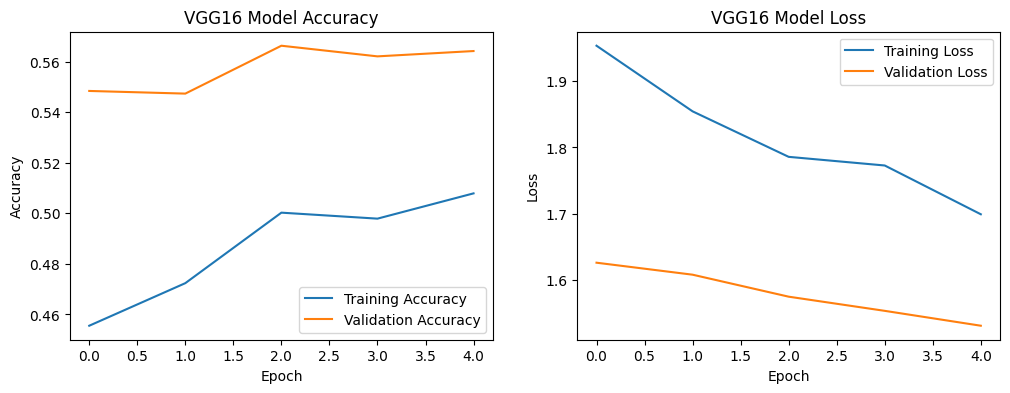

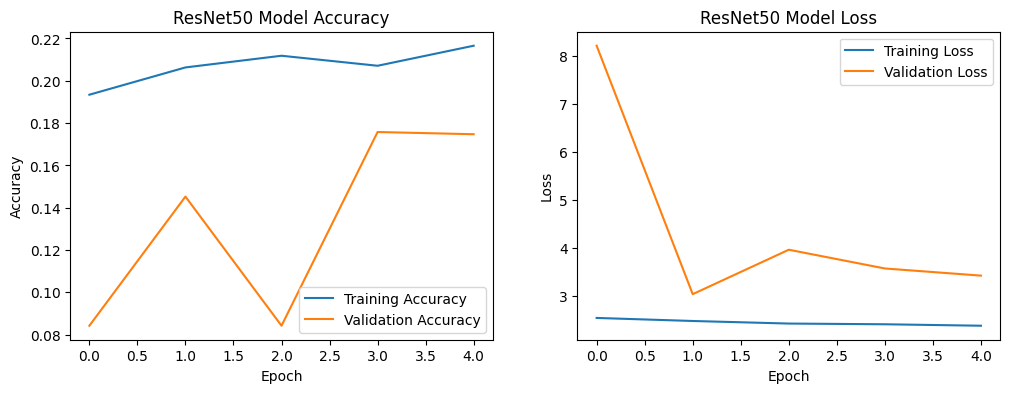

In [30]:
# Plot accuracy and loss curves for both models
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} Model Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} Model Loss')

    plt.show()

plot_history(history_vgg16, "VGG16")
plot_history(history_resnet50, "ResNet50")


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


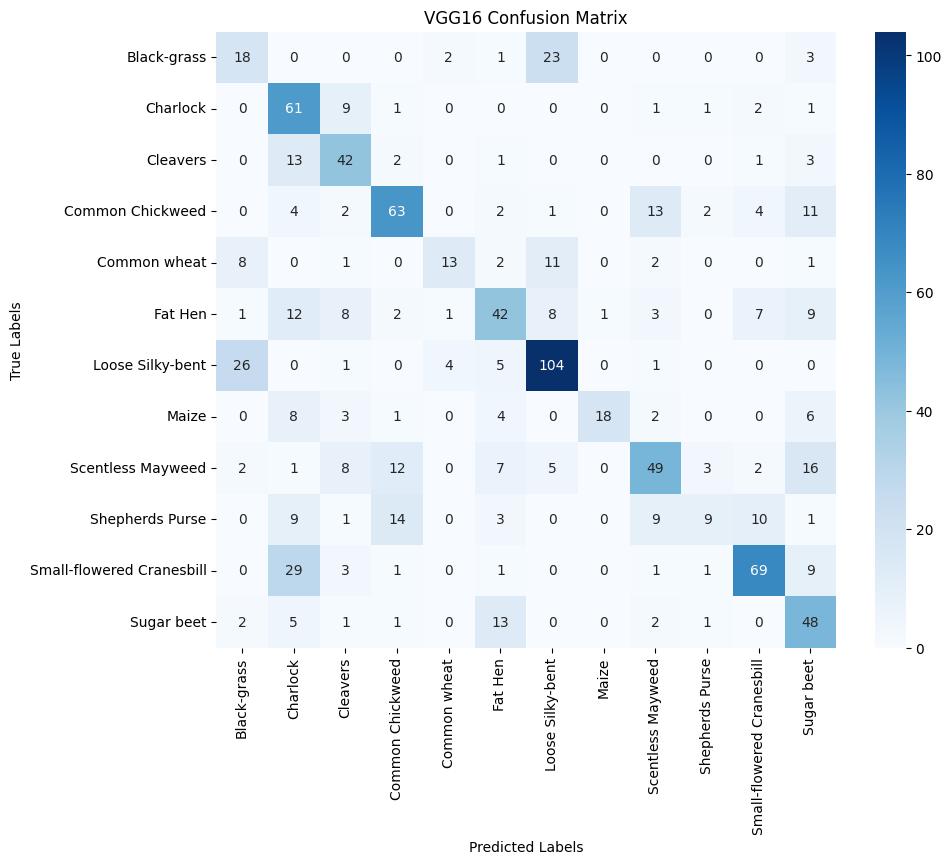

VGG16 Classification Report:
                            precision    recall  f1-score   support

              Black-grass       0.32      0.38      0.35        47
                 Charlock       0.43      0.80      0.56        76
                 Cleavers       0.53      0.68      0.60        62
         Common Chickweed       0.65      0.62      0.63       102
             Common wheat       0.65      0.34      0.45        38
                  Fat Hen       0.52      0.45      0.48        94
         Loose Silky-bent       0.68      0.74      0.71       141
                    Maize       0.95      0.43      0.59        42
        Scentless Mayweed       0.59      0.47      0.52       105
          Shepherds Purse       0.53      0.16      0.25        56
Small-flowered Cranesbill       0.73      0.61      0.66       114
               Sugar beet       0.44      0.66      0.53        73

                 accuracy                           0.56       950
                macro avg     

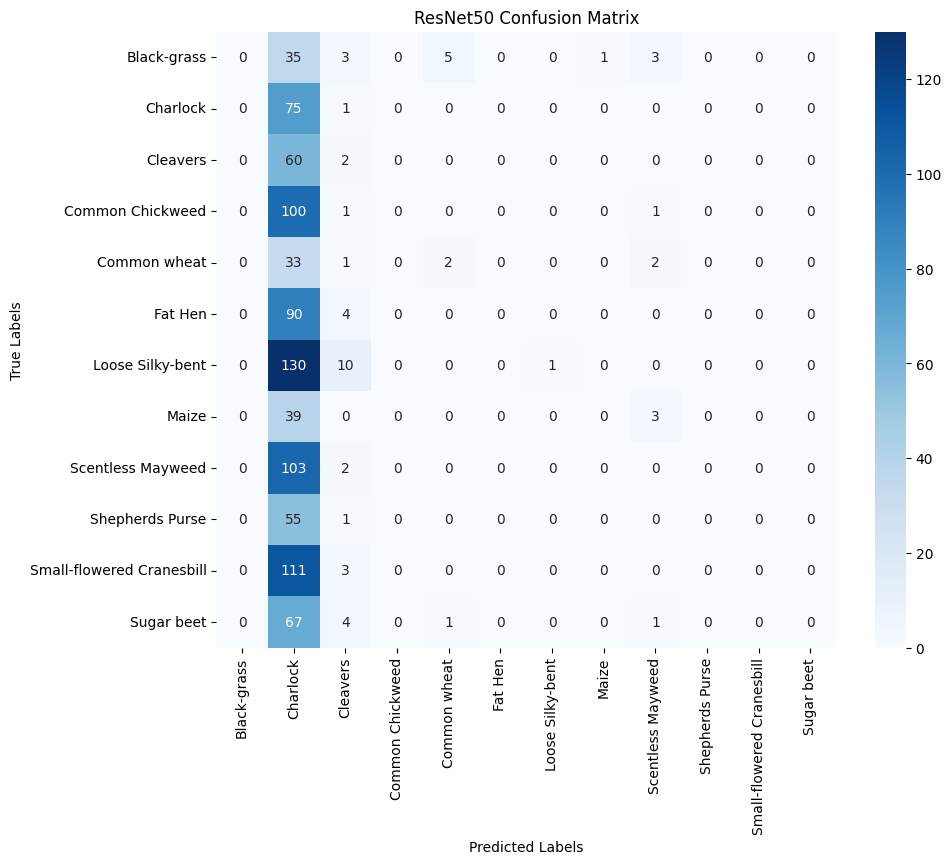

ResNet50 Classification Report:
                            precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        47
                 Charlock       0.08      0.99      0.15        76
                 Cleavers       0.06      0.03      0.04        62
         Common Chickweed       0.00      0.00      0.00       102
             Common wheat       0.25      0.05      0.09        38
                  Fat Hen       0.00      0.00      0.00        94
         Loose Silky-bent       1.00      0.01      0.01       141
                    Maize       0.00      0.00      0.00        42
        Scentless Mayweed       0.00      0.00      0.00       105
          Shepherds Purse       0.00      0.00      0.00        56
Small-flowered Cranesbill       0.00      0.00      0.00       114
               Sugar beet       0.00      0.00      0.00        73

                 accuracy                           0.08       950
                macro avg  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X_val, y_val, model_name):
    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # Print classification report
    print(f"{model_name} Classification Report:\n",
          classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Evaluate both models
evaluate_model(best_vgg16_model, X_val, y_val, "VGG16")
evaluate_model(best_resnet50_model, X_val, y_val, "ResNet50") # Use the tuned ResNet50 model: best_resnet50_model

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


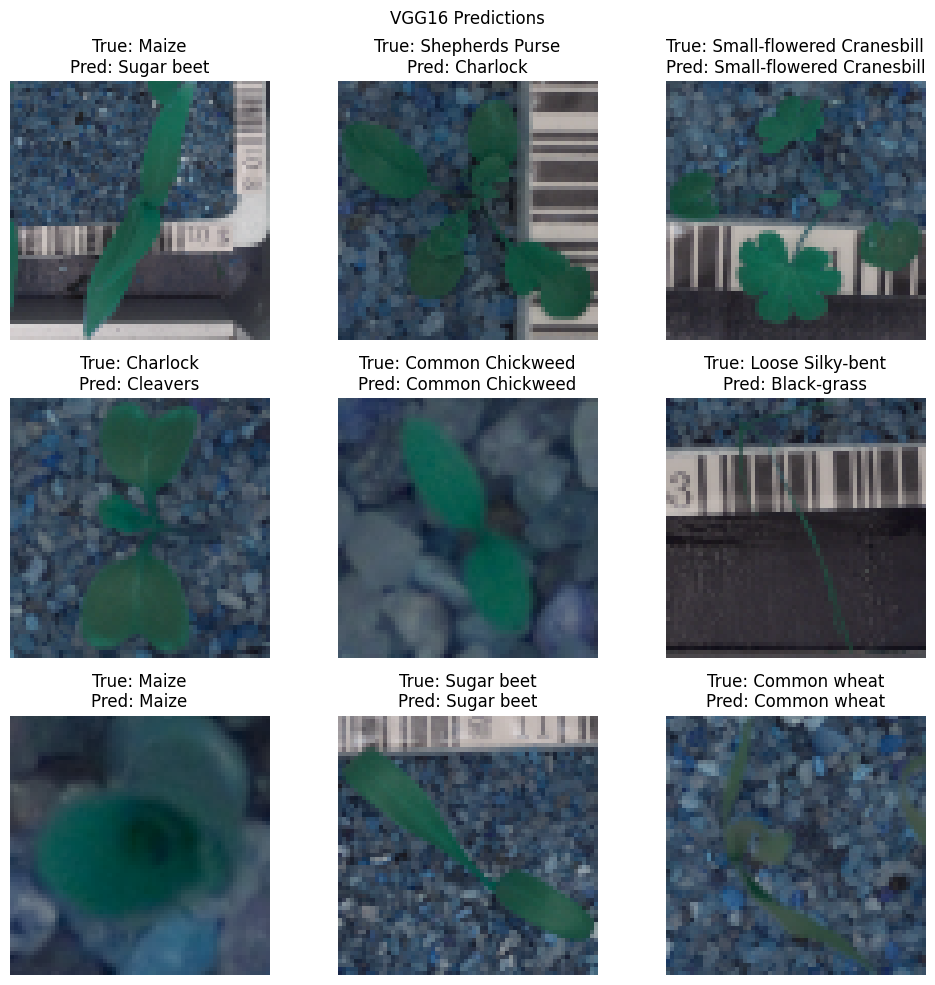

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


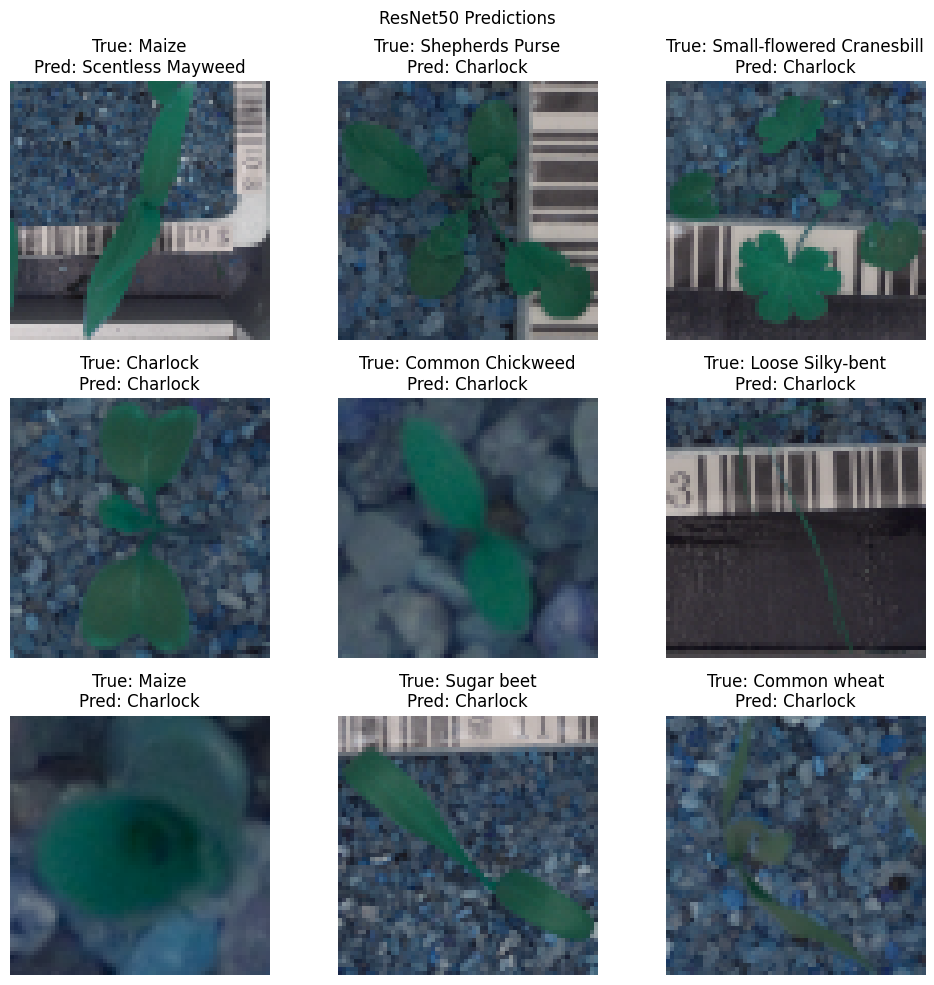

In [32]:
def plot_predictions(model, X_val, y_val, model_name):
    y_pred_classes = np.argmax(model.predict(X_val), axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(9):
        img = X_val[i]
        true_label = label_encoder.classes_[y_true_classes[i]]
        pred_label = label_encoder.classes_[y_pred_classes[i]]

        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
        axes[i].axis('off')

    plt.suptitle(f"{model_name} Predictions")
    plt.tight_layout()
    plt.show()

# Plot predictions for both models
plot_predictions(best_vgg16_model, X_val, y_val, "VGG16")
plot_predictions(best_resnet50_model, X_val, y_val, "ResNet50")


6. Model Comparison and F1 Score Analysis

In [33]:
from sklearn.metrics import classification_report
import pandas as pd

# Function to calculate the macro F1 score for a model
def get_f1_score(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Get classification report
    report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)
    f1_score = report['macro avg']['f1-score']  # Get macro F1 score
    return f1_score

# Calculate F1 scores for each model
f1_scores = {
    "Basic CNN": get_f1_score(model_1, X_val, y_val),
    "Enhanced CNN": get_f1_score(model_2, X_val, y_val),
    "VGG16 Transfer Learning": get_f1_score(best_vgg16_model, X_val, y_val),
    "ResNet50 Transfer Learning": get_f1_score(best_resnet50_model, X_val, y_val)
}


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
# Convert F1 scores dictionary to DataFrame
f1_scores_df = pd.DataFrame(list(f1_scores.items()), columns=['Model', 'F1 Score'])
print(f1_scores_df)


                        Model  F1 Score
0                   Basic CNN  0.490674
1                Enhanced CNN  0.358863
2     VGG16 Transfer Learning  0.526797
3  ResNet50 Transfer Learning  0.024800


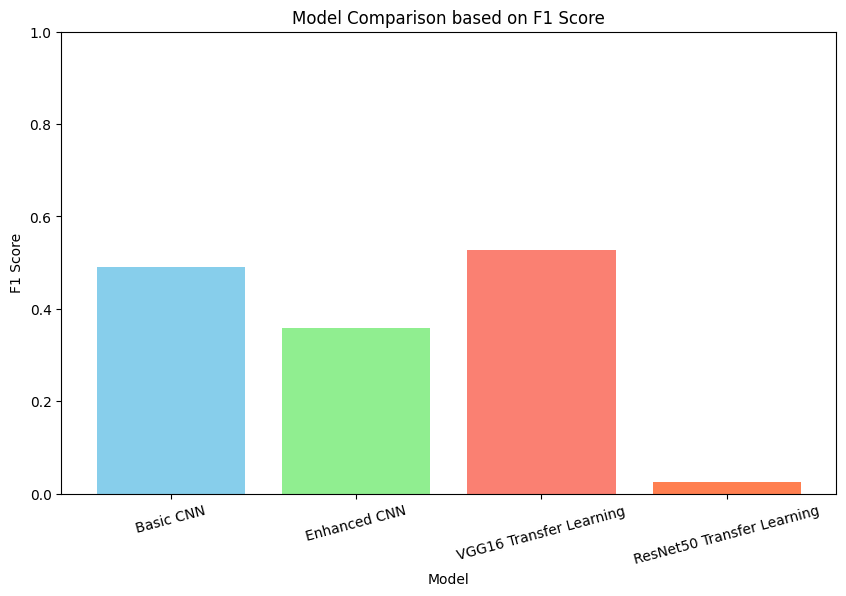

In [35]:
import matplotlib.pyplot as plt

# Plot F1 scores as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(f1_scores_df['Model'], f1_scores_df['F1 Score'], color=['skyblue', 'lightgreen', 'salmon', 'coral'])
plt.title('Model Comparison based on F1 Score')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim(0, 1)  # F1 Score ranges from 0 to 1
plt.xticks(rotation=15)
plt.show()
